In [2]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [0]:
import split_folders
split_folders.ratio('/content/drive/My Drive/GroupProject', output='/content/drive/My Drive/Dataset_Graffiti',
                    seed=1337, ratio=(0.8, 0.0, 0.1)) 

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D,MaxPooling3D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from tensorflow import keras
from keras import backend as K 

Using TensorFlow backend.


In [3]:
trainpath= '/content/drive/My Drive/Dataset_Graffiti/train'
validpath='/content/drive/My Drive/Dataset_Graffiti/val'
testpath='/content/drive/My Drive/Dataset_Graffiti/test'

Width=224
Height=224
Batch_Size=100
# Data Augumentation 
# To balance the dataset and to increase the size of training nd testing dataset
# Regularization technique to minimize overfitting
# Rescaling the image is Normalizing the image
train_data_generator= ImageDataGenerator(shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True, 
                                         preprocessing_function=preprocess_input 
                                         )

train_set = train_data_generator.flow_from_directory(trainpath,
                                                    target_size=(Width,Height),
                                                    batch_size=Batch_Size,
                                                    class_mode='binary'                                                   
                                                  )
valid_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

valid_set = valid_data_generator.flow_from_directory(validpath,
                                                    target_size=(Width,Height),
                                                    batch_size=Batch_Size,
                                                    class_mode='binary', shuffle=False 
                                                        )

test_data_generator= ImageDataGenerator()

test_set = test_data_generator.flow_from_directory(testpath,
                                                  target_size=(Width,Height),
                                                  batch_size=Batch_Size, class_mode='binary', 
                                                   shuffle=False
                                                    )

# To print number of batches per epoch
print('Number of Batches per epoch train=%d, valid=%d ,test=%d' % (len(train_set), len(valid_set),len(test_set)))

Found 1804 images belonging to 2 classes.
Found 224 images belonging to 2 classes.
Found 228 images belonging to 2 classes.
Number of Batches per epoch train=19, valid=3 ,test=3


In [4]:
# pretrained Resent model
base_model_100= applications.ResNet50(include_top=False, weights='imagenet', input_shape=(Width, Height,3))
base_model_100.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [5]:
# Adding custom layers
x = base_model_100.output
# gap= sum of all elements/number of all (which ia a 1*1)
x = GlobalAveragePooling2D()(x) # To reduce the Number of parameters that feed to future FC layer which reduce the total weights and can improve training speed
# x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.3)(x) # Regularization method to minimize overfitting 
#x = Dense(256, activation='relu')(x)
#x = Dropout(0.3)(x) # Regularization method to minimize overfitting
predictions = Dense(1, activation='sigmoid')(x)

# creating the final model 
model_final_100 = Model(inputs = base_model_100.input, outputs = predictions)

# Freezing first seven layers
for layer in model_final_100.layers[:-4]:
    layer.trainable = False

# compile the model 
# Learning rate should be tuned
# beta1= 0.9 (first moment)
#beta2=0.999 (second moment)
#Epsilon=10-8............beta_1=0.9, beta_2=0.999
model_final_100.compile(loss = "binary_crossentropy", optimizer = optimizers.Adam(lr=0.0001), metrics=["accuracy"]) # Adam- Adaptive moment estimation
model_final_100.summary()
# print ('model output shape:', model_final.output_shape) 


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
______________________________________________________________________________

In [6]:
# Saving the model according to the conditions  
checkpoint = ModelCheckpoint("Resnet_100.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='auto')

# Early Stopping is a regularization method (To minimize overfitting)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

import math
# Train the model
train_100= model_final_100.fit_generator(
                                train_set,
                                steps_per_epoch = train_set.samples//train_set.batch_size,
                                epochs = 40,
                                validation_data = valid_set,
                                validation_steps = valid_set.samples//valid_set.batch_size,
                                callbacks=[checkpoint,early])




Epoch 1/40
18/18 [==============================] - 525s 29s/step - loss: 0.5716 - acc: 0.7164 - val_loss: 0.4559 - val_acc: 0.8000

Epoch 00001: val_acc improved from -inf to 0.80000, saving model to Resnet_100.h5
Epoch 2/40
18/18 [==============================] - 487s 27s/step - loss: 0.4062 - acc: 0.8191 - val_loss: 0.5180 - val_acc: 0.7742

Epoch 00002: val_acc did not improve from 0.80000
Epoch 3/40
18/18 [==============================] - 507s 28s/step - loss: 0.3744 - acc: 0.8261 - val_loss: 0.3267 - val_acc: 0.8710

Epoch 00003: val_acc improved from 0.80000 to 0.87097, saving model to Resnet_100.h5
Epoch 4/40
18/18 [==============================] - 479s 27s/step - loss: 0.3041 - acc: 0.8784 - val_loss: 0.4713 - val_acc: 0.7950

Epoch 00004: val_acc did not improve from 0.87097
Epoch 5/40
18/18 [==============================] - 484s 27s/step - loss: 0.3304 - acc: 0.8525 - val_loss: 1.0213 - val_acc: 0.5484

Epoch 00005: val_acc did not improve from 0.87097
Epoch 6/40
18/18

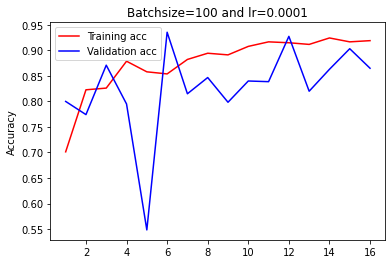

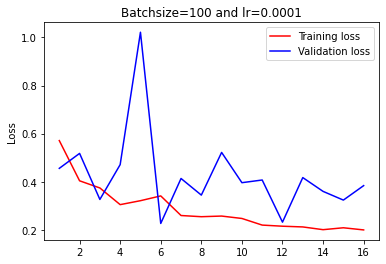

In [9]:
import matplotlib.pyplot as plt
acc = train_100.history['acc']
val_acc = train_100.history['val_acc']
loss = train_100.history['loss']
val_loss = train_100.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.ylabel("Accuracy")
plt.title('Batchsize=100 and lr=0.0001')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.ylabel("Loss")
plt.title('Batchsize=100 and lr=0.0001')
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)


Confusion Matrix
[[99 15]
 [19 95]]
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       114
           1       0.86      0.83      0.85       114

    accuracy                           0.85       228
   macro avg       0.85      0.85      0.85       228
weighted avg       0.85      0.85      0.85       228



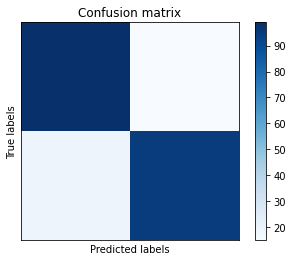

In [8]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np

steps= np.math.ceil(test_set.samples / test_set.batch_size)
Y_pred = model_final_100.predict_generator(test_set, steps)
y_pred = Y_pred >= 0.5

print('Confusion Matrix')
cm = metrics.confusion_matrix(test_set.classes, y_pred)
print(cm)
print('Classification Report')
print(metrics.classification_report(test_set.classes, y_pred))
cm = metrics.confusion_matrix(test_set.classes, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix')
plt.colorbar()
plt.show()